In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import os

In [2]:
files = []
PATH = "/Users/marron31/repos/bcm4rcm/data/processed"
for file in os.listdir(PATH):
    if file.endswith(".csv"):
        if '1961' in file:
            files.append(os.path.join(PATH, file))
            
files

['/Users/marron31/repos/bcm4rcm/data/processed/historical_MPI_IITM_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_CSIRO_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_MPI-REMO2009_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_NOAA_SMHI_1961_1975.csv',
 '/Users/marron31/repos/bcm4rcm/data/processed/historical_MIROC_1961_1975.csv']

In [3]:
def aggregate_to_4d_array(df, agg_func='mean'):
    """
    Aggregates values from a DataFrame for each month, latitude, longitude, and year,
    then reshapes the result into a 4D NumPy array.
    
    Parameters:
    - df: Pandas DataFrame with columns ['time', 'lat', 'lon', 'tp']
    - agg_func: String name of the aggregation function to use (e.g., 'mean', 'sum')
    
    Returns:
    - A 4D NumPy array with shape [12, 90, 40, -1], where -1 is the number of years
    """
    # Ensure 'time' is a datetime type
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract month and year
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year - df['time'].dt.year.min()  # Normalize year
    
    # Group and aggregate
    aggregated_df = df.groupby(['month', 'lat', 'lon', 'year'])['tp'].agg(agg_func).reset_index()
    
    # Pivot
    pivoted_df = aggregated_df.pivot_table(index=['month', 'lat', 'lon'], columns='year', values='tp', fill_value=0)
    
    # Convert to a 4D array and reshape
    num_years = len(df['year'].unique())
    result_array = pivoted_df.values.reshape((12, 90, 40, num_years))
    
    return result_array

# Example usage:
# Assuming your DataFrame is named df and has the required columns
# result_array = aggregate_to_4d_array(df, agg_func='mean')
# Now result_array is the desired 4D array


In [4]:
rcm_dict = {}
for file in files:
    df = pd.read_csv(file)
    df = aggregate_to_4d_array(df)
    rcm_dict[file.split('/')[-1].split('_')[1]] = df

In [5]:
for k,v in rcm_dict.items():
    print(k, v.shape)

MPI (12, 90, 40, 15)
CSIRO (12, 90, 40, 15)
MPI-REMO2009 (12, 90, 40, 15)
NOAA (12, 90, 40, 15)
MIROC (12, 90, 40, 15)


In [6]:
np.random.seed(0)

In [7]:
weights_dict = {}
for k,v in rcm_dict.items():
    weights_dict[k] = np.round(np.random.rand(1),2)

In [8]:
for k,v in rcm_dict.items():
    v = np.repeat(v, int(weights_dict[k]*100), axis=3)
    rcm_dict[k] = v

/var/folders/20/mmwsmqln50jb9dbszgvt2l240000gp/T/ipykernel_93003/1660977929.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = np.repeat(v, int(weights_dict[k]*100), axis=3)


In [9]:
for k,v in rcm_dict.items():
    print(v.shape)

(12, 90, 40, 825)
(12, 90, 40, 1080)
(12, 90, 40, 900)
(12, 90, 40, 810)
(12, 90, 40, 630)


In [55]:
# Creata a 5D array with the values for all the RCMs
rcms = np.concatenate([rcm_dict[i] for i in list(rcm_dict.keys())], axis=-1)

/var/folders/20/mmwsmqln50jb9dbszgvt2l240000gp/T/ipykernel_93003/169589089.py:3: RuntimeWarning: divide by zero encountered in log
  log_rcms = np.log(rcms)


In [56]:
# Transform the values to log and add a small value to avoid log(0)
epsilon=1e-5
log_rcms = np.log(rcms+epsilon)

In [63]:
# Placeholder for KDE results
kde_results = np.empty((12, 90, 40), dtype=object)

data = log_rcms

# Iterate over the array
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            # Extract the vector
            sample = data[i, j, k, :]
            
            # Apply KDE
            kde = gaussian_kde(sample)
            
            # Store the KDE object (or you could store the estimated densities)
            kde_results[i, j, k] = kde

0
1
2
3
4
5
6
7
8
9
10
11


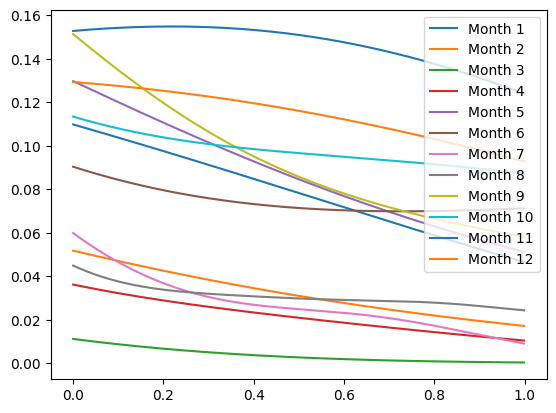

In [64]:
for idx, kde in enumerate(kde_results[:, 0, 0]):
    x = np.arange(0, 1, 0.001)
    y = kde.evaluate(x)
    plt.plot(x, y, label=f'Month {idx + 1}')
plt.legend()
plt.show()

In [17]:
PATH = "/Users/marron31/repos/bcm4rcm/data/APHRODITE/aphrodite_hma_1951_2016.nc"
ds = xr.open_dataset(PATH)

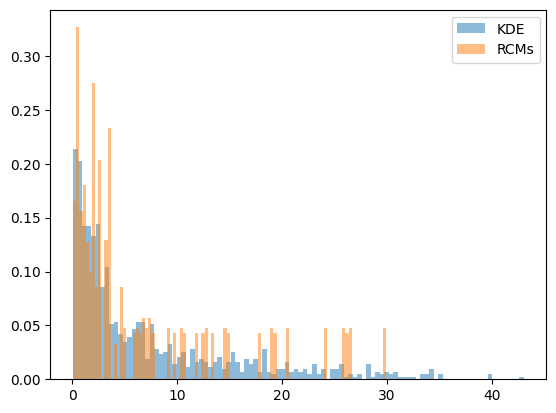

In [75]:
i = 7
j = 5
k = 6

plt.hist(np.exp(kde_results[i,j,k].resample(1000)).reshape(-1)-epsilon, bins=100, alpha=0.5, label='KDE', density=True)
plt.hist(np.exp(data[i,j,k,:])-epsilon, bins=100, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()

### APHRODITE

In [15]:
# select data for  period 1961-1975 and spatial extent of interest
ds_sel = ds.sel(time=slice('1961-01-01', '1975-12-31')).sel(lat=slice(20, 40), lon=slice(60, 105))